<a href="https://colab.research.google.com/github/greght/Workshop-FastAi-Segmentation/blob/main/ImageSegmentation_fastAI_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See the example at https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb

See the CSCAR workshop slides: https://docs.google.com/presentation/d/1fNLdRztw5u_k1JzTPfLYPUnqTbRiN_5wCrE9fL_t3BQ/edit?usp=sharing 

Dataset: http://www.josiahwang.com/dataset/leedsbutterfly/

>Josiah Wang, Katja Markert, and Mark Everingham\
>**Learning Models for Object Recognition from Natural Language Descriptions**\
>In *Proceedings of the 20th British Machine Vision Conference* (BMVC2009)



In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
import os
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget http://www.josiahwang.com/dataset/leedsbutterfly/leedsbutterfly_dataset_v1.0.zip

--2020-10-06 17:23:24--  http://www.josiahwang.com/dataset/leedsbutterfly/leedsbutterfly_dataset_v1.0.zip
Resolving www.josiahwang.com (www.josiahwang.com)... 143.95.240.28
Connecting to www.josiahwang.com (www.josiahwang.com)|143.95.240.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 476389461 (454M) [application/zip]
Saving to: ‘leedsbutterfly_dataset_v1.0.zip’

leedsbutterfly_data 100%[===================>] 454.32M  41.4MB/s    in 9.3s    

2020-10-06 17:23:34 (49.0 MB/s) - ‘leedsbutterfly_dataset_v1.0.zip’ saved [476389461/476389461]



In [ ]:
!unzip -q leedsbutterfly_dataset_v1.0.zip

In [ ]:
path_lbl = 'leedsbutterfly/segmentations'
path_img = 'leedsbutterfly/images'

In [ ]:
# Rescale masks to 0 and 1 (instead of 0 and 255)
for filename in os.listdir(path_lbl):
  if filename.endswith(".png"):
    maskIn = cv2.imread(f'{path_lbl}/{filename}',cv2.IMREAD_UNCHANGED)
    maskOut = maskIn.copy()
    maskOut[maskIn<128] = 0
    maskOut[maskIn>0] = 1
    cv2.imwrite(f'{path_lbl}/{filename.split(".")[0]}_mask.png',maskOut)

In [ ]:
# Create lists of image and label files
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

In [ ]:
# Given the image filename, this function returns the mask filename
get_y_fn = lambda x: f'{path_lbl}/{x.stem}_seg0_mask.png'

leedsbutterfly/images/0010044.png
leedsbutterfly/segmentations/0010044_seg0_mask.png


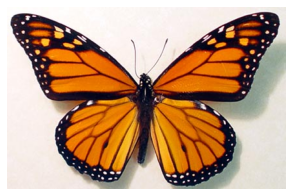

In [ ]:
# Show an image, as an example
img_f = fnames[0]
print(img_f)
print(get_y_fn(img_f))
img = open_image(img_f)
img.show(figsize=(5,5))

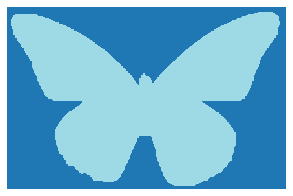

In [ ]:
# And now, show the corresponding mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
# Give names to the label indices
codes = np.array(['Background','Butterfly'], dtype=str); codes

array(['Background', 'Butterfly'], dtype='<U10')

In [ ]:
# Define an image size and batch size
size = 224
bs=4

In [ ]:
# Specify the methods to read in from the source
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
# Now, actually read in the data
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

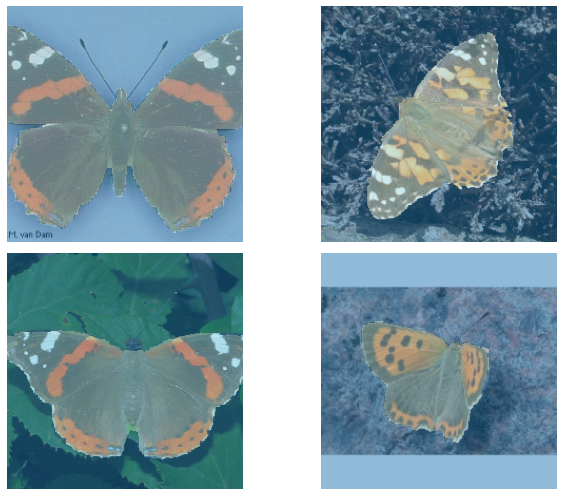

In [ ]:
# Show a batch (mask superimposed on image), as an example
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [ ]:
# Define the accuracy metric
def acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [ ]:
metrics=acc

In [ ]:
wd=1e-2

In [ ]:
# Load the fast.ai unet object
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


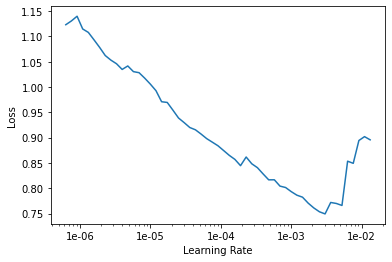

In [ ]:
# Do a search to find a good learning rate
lr_find(learn)
learn.recorder.plot()

In [ ]:
# Define the learning rate
lr=1e-3

In [ ]:
# Perform training for 15 epochs
learn.fit_one_cycle(15, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc,time
0,0.166699,0.109981,0.956534,00:26
1,0.145415,0.265947,0.892712,00:25
2,0.081492,0.079624,0.970479,00:24
3,0.079358,0.060898,0.975523,00:24
4,0.065516,0.046379,0.982077,00:25
5,0.059896,0.054622,0.981325,00:24
6,0.054770,0.037561,0.985891,00:25
7,0.051140,0.043438,0.985431,00:25
8,0.051813,0.064996,0.981195,00:25
9,0.055185,0.037486,0.986264,00:24


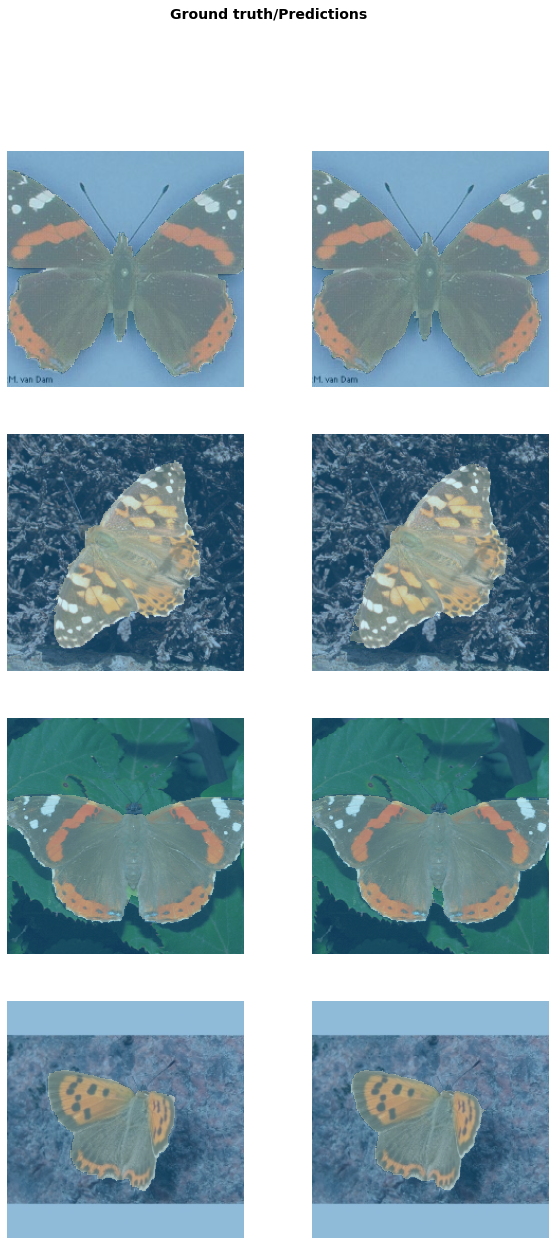

In [ ]:
# Show some example predicitons (truth: left, prediction: right)
learn.show_results(ds_type=DatasetType.Valid,rows=4, figsize=(10,20))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
# Unfreeze the weights of the convolutional layers for fine tuning
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
# Perform the fine tuning
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc,time
0,0.025463,0.026169,0.989939,00:27
1,0.025486,0.025987,0.989937,00:26
2,0.027186,0.027022,0.989734,00:26
3,0.023878,0.024801,0.990488,00:26
4,0.022778,0.023889,0.990630,00:26


In [ ]:
learn.save('stage-2')

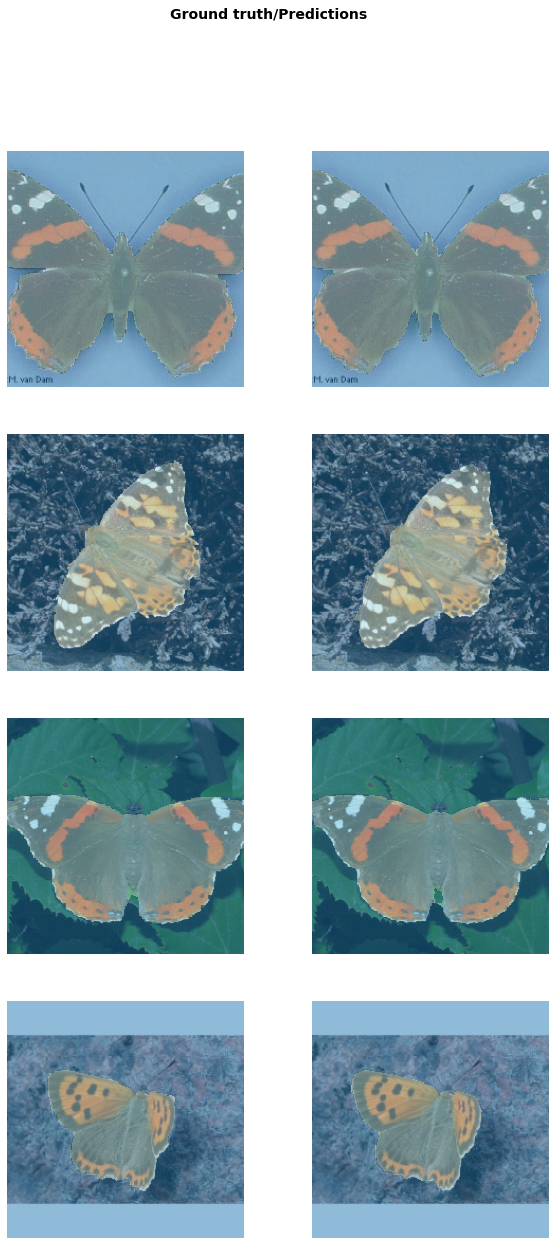

In [ ]:
learn.show_results(ds_type=DatasetType.Valid,rows=10, figsize=(10,20))

In [ ]:
learn.export()